# MLP for Sine Wave Prediction
## MSE23185 - Tran Trong Hieu
## Excercise 3: Build a 3-layer MLP for Sine Wave Prediction with a following configurations:
- Using He weight initialization
- Using activation function in hidden layers: LeakyReLU
- Using number of neurons in each layer: 100; 200
- Using loss function : MAE, MSE
- Optimizer: RMSProb

In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt

# Generate sine wave data
np.random.seed(42)
X = np.linspace(-2 * np.pi, 2 * np.pi, 1000).reshape(-1, 1) # Input feature
y = np.sin(X) + 0.1 * np.random.randn(*X.shape) # Target with some noise

# Define the LeakyReLU activation function
def leakyRelu(x, alpha = 0.01):
    return np.maximum(alpha * x, x)

# Define the derivative of the LeakyReLU function
def leakyRelu_derivative(x, alpha = 0.01):
    return np.where(x > 0, 1, alpha)

# Mean Squared Error loss function
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Derivative of MSE with respect to prediction
def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

# Mean Absolute Error loss function
def mae_loss(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Derivative of MAE with respect to prediction
def mae_loss_derivative(y_true, y_pred):
    return np.where(y_pred > y_true, 1, -1) / y_true.size

# Initialize weights and biases
def initialize_parameters(input_size, hidden_size, output_size, num_hidden_layers = 2):
    parameters = {}
    parameters['W1'] = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
    parameters['b1'] = np.random.randn(1, hidden_size)

    for i in range(2, num_hidden_layers + 1):
        parameters[f'W{i}'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(2 / hidden_size)
        parameters[f'b{i}'] = np.random.randn(1, hidden_size)

    parameters[f'W{num_hidden_layers + 1}'] = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
    parameters[f'b{num_hidden_layers + 1}'] = np.random.randn(1, output_size)

    return parameters

# Forward pass
def forward(X, parameters, num_hidden_layers = 2):
    cache = {}

    A = X

    for i in range(1, num_hidden_layers + 1):
        Z = np.dot(A, parameters[f'W{i}']) + parameters[f'b{i}']
        A = leakyRelu(Z)
        cache[f'Z{i}'] = Z
        cache[f'A{i}'] = A

    # Output layer (linear function)
    Z_output = np.dot(A, parameters[f'W{num_hidden_layers + 1}']) + parameters[f'b{num_hidden_layers + 1}']
    cache[f'Z{num_hidden_layers + 1}'] = Z_output

    return Z_output, cache

# Backward pass with RMSProp
def backward(X, y, parameters, cache, squared_gradients, num_hidden_layers = 2, learning_rate = 0.001, beta = 0.9, epsilon = 1e-8, loss_type = 'MSE'):
    m = y.size
    grads = {}

    if loss_type == 'MAE':
        dZ_output = mae_loss_derivative(y, cache[f'Z{num_hidden_layers + 1}'])
    else:
        dZ_output = mse_loss_derivative(y, cache[f'Z{num_hidden_layers + 1}'])

    grads[f'dW{num_hidden_layers + 1}'] = np.dot(cache[f'A{num_hidden_layers}'].T, dZ_output) / m
    grads[f'db{num_hidden_layers + 1}'] = np.sum(dZ_output, axis = 0, keepdims = True) / m

    dA_prev = np.dot(dZ_output, parameters[f'W{num_hidden_layers + 1}'].T)

    for i in range(num_hidden_layers, 0, -1):
        dZ = dA_prev * leakyRelu_derivative(cache[f'Z{i}'])
        grads[f'dW{i}'] = np.dot((X if i == 1 else cache[f'A{i - 1}']).T, dZ) / m
        grads[f'db{i}'] = np.sum(dZ, axis = 0, keepdims = True) / m
        if i > 1:
            dA_prev = np.dot(dZ, parameters[f'W{i}'].T)

    for i in range(1, num_hidden_layers + 2):
        squared_gradients[f'W{i}'] = beta * squared_gradients[f'W{i}'] + (1 - beta) * grads[f'dW{i}'] ** 2
        squared_gradients[f'b{i}'] = beta * squared_gradients[f'b{i}'] + (1 - beta) * grads[f'db{i}'] ** 2

        parameters[f'W{i}'] -= learning_rate * grads[f'dW{i}'] / (np.sqrt(squared_gradients[f'W{i}']) + epsilon)
        parameters[f'b{i}'] -= learning_rate * grads[f'db{i}'] / (np.sqrt(squared_gradients[f'b{i}']) + epsilon)

    return parameters, squared_gradients

# Training loop
def train(X, y, hidden_size = 100, epochs = 5000, learning_rate = 0.001, beta = 0.9, loss_type = 'MSE'):
    input_size = X.shape[1]
    output_size = 1 # We want 1 output (regression)
    num_hidden_layers = 2

    # Initialize parameters
    parameters = initialize_parameters(input_size, hidden_size, output_size, num_hidden_layers)
    squared_gradients = {k: np.zeros_like(v) for k, v in parameters.items()}

    # Training loop
    for epoch in range(epochs):
        # Forward pass
        y_pred, cache = forward(X, parameters, num_hidden_layers)

        # Compute loss
        if loss_type == 'MAE':
            loss = mae_loss(y, y_pred)
        else:
            loss = mse_loss(y, y_pred)

        # Backward pass and update parameters
        parameters, squared_gradients = backward(X, y, parameters, cache, squared_gradients, num_hidden_layers, learning_rate, beta, loss_type = loss_type)

        # Print loss every 100 epochs
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

    return parameters

# Prediction
def predict(X, parameters, num_hidden_layers = 2):
    y_pred, _ = forward(X, parameters, num_hidden_layers)
    return y_pred

## 1. Number of neurons in each layer: 100 and loss function: MSE

Epoch 0, Loss: 35.13854674709325
Epoch 1000, Loss: 0.23353915756171068
Epoch 2000, Loss: 0.10404432310770226
Epoch 3000, Loss: 0.05046941495719331
Epoch 4000, Loss: 0.026408507946201667
Epoch 5000, Loss: 0.018567290952877295
Epoch 6000, Loss: 0.01626659660717761
Epoch 7000, Loss: 0.013736927928688048
Epoch 8000, Loss: 0.01267836558515153
Epoch 9000, Loss: 0.012053550371458048


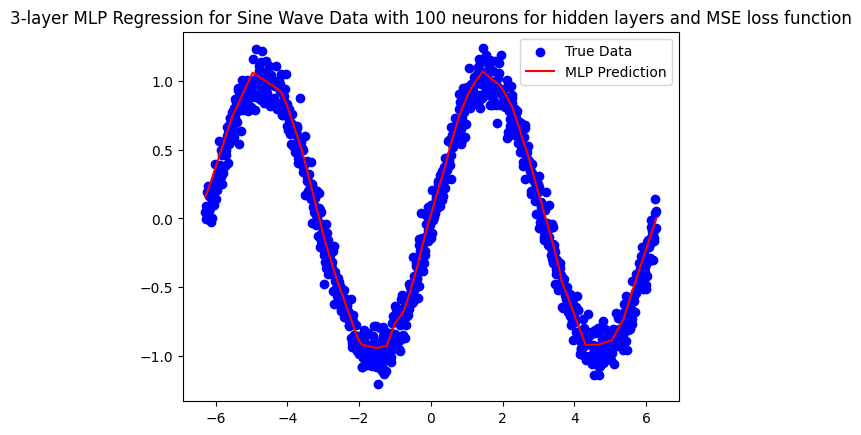

In [2]:
# Train the MLP
parameters = train(X, y, hidden_size = 100, epochs = 10000, learning_rate = 0.001, loss_type = 'MSE')

# Predict on the training data
y_pred = predict(X, parameters)

# Plot the results
plt.scatter(X, y, label='True Data', color='blue')
plt.plot(X, y_pred, label='MLP Prediction', color='red')
plt.legend()
plt.title('3-layer MLP Regression for Sine Wave Data with 100 neurons for hidden layers and MSE loss function')
plt.show()

## 2. Number of neurons in each layer: 200 and loss function: MSE

Epoch 0, Loss: 108.11479135598223
Epoch 1000, Loss: 0.25311611979675486
Epoch 2000, Loss: 0.09239540716169899
Epoch 3000, Loss: 0.02812575496494628
Epoch 4000, Loss: 0.02181803453491297
Epoch 5000, Loss: 0.01761565721953432
Epoch 6000, Loss: 0.01587144424202704
Epoch 7000, Loss: 0.015270545959266819
Epoch 8000, Loss: 0.014227656803191017
Epoch 9000, Loss: 0.01421623775600775


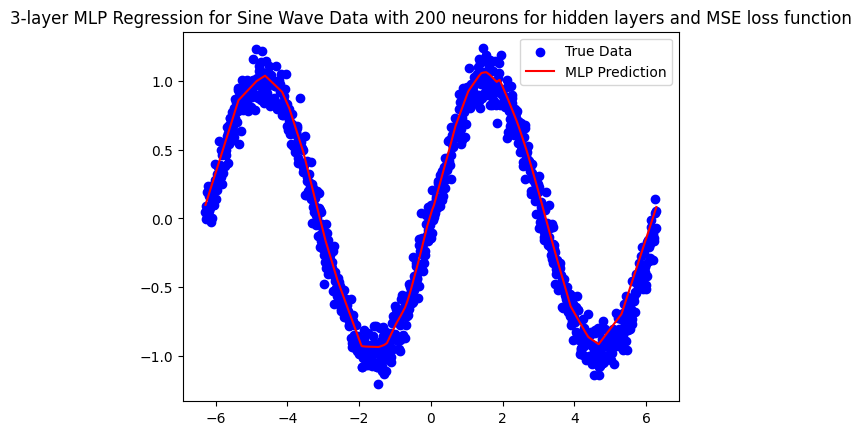

In [4]:
# Train the MLP
parameters = train(X, y, hidden_size = 200, epochs = 10000, learning_rate = 0.001, loss_type = 'MSE')

# Predict on the training data
y_pred = predict(X, parameters)

# Plot the results
plt.scatter(X, y, label='True Data', color='blue')
plt.plot(X, y_pred, label='MLP Prediction', color='red')
plt.legend()
plt.title('3-layer MLP Regression for Sine Wave Data with 200 neurons for hidden layers and MSE loss function')
plt.show()

## 3. Number of neurons in each layer: 100 and loss function: MAE

Epoch 0, Loss: 3.4748357980472666
Epoch 1000, Loss: 0.2916239211029322
Epoch 2000, Loss: 0.1981572845123069
Epoch 3000, Loss: 0.15172443544430975
Epoch 4000, Loss: 0.12022516654540817
Epoch 5000, Loss: 0.1054515766880122
Epoch 6000, Loss: 0.09612228041450269
Epoch 7000, Loss: 0.09132668131150116
Epoch 8000, Loss: 0.09097833965039001
Epoch 9000, Loss: 0.08687171561723375


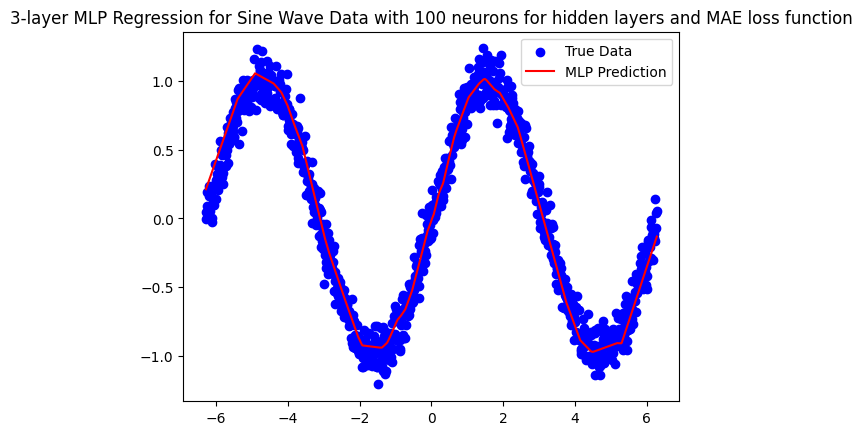

In [5]:
# Train the MLP
parameters = train(X, y, hidden_size = 100, epochs = 10000, learning_rate = 0.001, loss_type = 'MAE')

# Predict on the training data
y_pred = predict(X, parameters)

# Plot the results
plt.scatter(X, y, label='True Data', color='blue')
plt.plot(X, y_pred, label='MLP Prediction', color='red')
plt.legend()
plt.title('3-layer MLP Regression for Sine Wave Data with 100 neurons for hidden layers and MAE loss function')
plt.show()

## 4. Number of neurons in each layer: 200 and loss function: MAE

Epoch 0, Loss: 2.517834904352492
Epoch 1000, Loss: 0.535687297645833
Epoch 2000, Loss: 0.27633233368361504
Epoch 3000, Loss: 0.1707210830439184
Epoch 4000, Loss: 0.11818324048734402
Epoch 5000, Loss: 0.10192556471311083
Epoch 6000, Loss: 0.09305328844339016
Epoch 7000, Loss: 0.09006787048708176
Epoch 8000, Loss: 0.08843750825939013
Epoch 9000, Loss: 0.0869236044462387


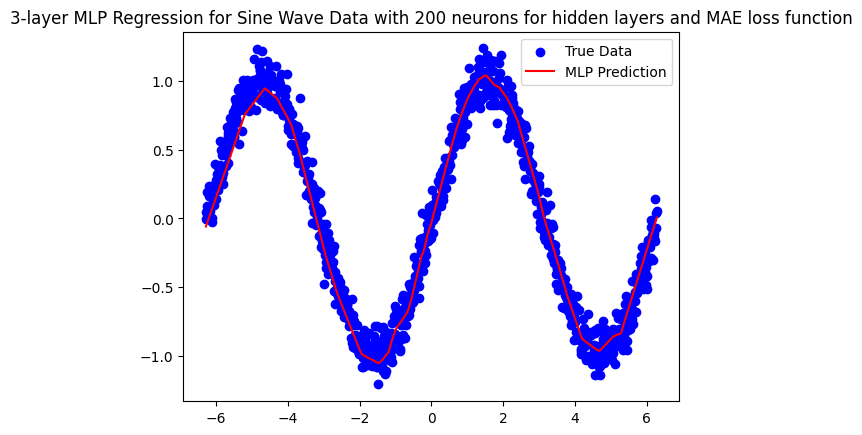

In [6]:
# Train the MLP
parameters = train(X, y, hidden_size = 200, epochs = 10000, learning_rate = 0.001, loss_type = 'MAE')

# Predict on the training data
y_pred = predict(X, parameters)

# Plot the results
plt.scatter(X, y, label='True Data', color='blue')
plt.plot(X, y_pred, label='MLP Prediction', color='red')
plt.legend()
plt.title('3-layer MLP Regression for Sine Wave Data with 200 neurons for hidden layers and MAE loss function')
plt.show()

## Nhận xét:
- Cả 4 mô hình đều có thời gian train nhanh, và có đường dự đoán tốt hơn, sát tập dữ liệu hơn nhiều so với các mô hình dùng ReLU activation function và SGD optimizer ở các bài trước.
- Việc dự đoán của các mô hình gần như giống nhau giữa mô hình 100 neurons với 200 neuron, tuy nhiên MSE loss function vẫn tốt hơn MAE function.
- Trong mô hình 200 neurons có một số đoạn giống hình zic-zac -> mô hình bị Overfitting ở một số đoạn